# BBC News Classification

Dataset Used - [BBC News Classification (Kaggle)](https://www.kaggle.com/competitions/learn-ai-bbc/data)

Other people have got high accuracy on test data after unsupervised training but extremely low accuracy when supervised. This suggests that test data has incorrect labels. Therefore I am not going to use it for testing.

In [1]:
import re

import numpy as np
import spacy
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# !python -m spacy download en_core_web_lg
nlp = spacy.load("en_core_web_lg")

## Data Cleaning

In [3]:
df = pd.read_csv("../dataset/train.csv")
df.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [4]:
print("Rows:", len(df))
print("Unique Labels:", len(df["Category"].unique()))

Rows: 1490
Unique Labels: 5


In [5]:
df = df.drop(columns=["ArticleId"])
df.head()

,Text,Category
0,worldcom ex-boss launches defence lawyers defe...,business
1,german business confidence slides german busin...,business
2,bbc poll indicates economic gloom citizens in ...,business
3,lifestyle governs mobile choice faster bett...,tech
4,enron bosses in $168m payout eighteen former e...,business


In [6]:
na_rows = df.isna().any(axis=1)
print("Null values:", na_rows.sum())
df = df.dropna()
print("Rows after removing null:", len(df))

Null values: 0
Rows after removing null: 1490


In [7]:
df.to_csv("../dataset/cleaned.csv", index=False)

## Data preprocessing

In [8]:
def preprocess(text):
    doc = nlp(text)
    processed_text = []
    for token in doc:
        if not (token.is_stop or token.is_punct or token.like_num):
            processed_text.append(token.lemma_)
    text = " ".join(processed_text)
    return re.sub(" +", " ", text)

df.Text = df.Text.apply(preprocess)
df.head()

,Text,Category
0,worldcom ex boss launch defence lawyer defend ...,business
1,german business confidence slide german busine...,business
2,bbc poll indicate economic gloom citizen major...,business
3,lifestyle govern mobile choice fast well funky...,tech
4,enron boss $ m payout enron director agree $ m...,business


In [9]:
label_map = df.Category.unique()
np.savetxt("../dataset/label_map.csv", label_map, fmt="%s", delimiter=",")
label_map = label_map.tolist()

def getLabels(series, label_map):
    return series.apply(lambda x: label_map.index(x)).to_numpy()

In [10]:
df.to_csv("../dataset/preprocessed.csv", index=False)

## Exploratory Data Analysis

In [11]:
df = pd.read_csv("../dataset/preprocessed.csv")
label_map = np.loadtxt("../dataset/label_map.csv", delimiter=",", dtype=str)
df.head()

,Text,Category
0,worldcom ex boss launch defence lawyer defend ...,business
1,german business confidence slide german busine...,business
2,bbc poll indicate economic gloom citizen major...,business
3,lifestyle govern mobile choice fast well funky...,tech
4,enron boss $ m payout enron director agree $ m...,business


{'business': 336, 'tech': 261, 'politics': 274, 'sport': 346, 'entertainment': 273}


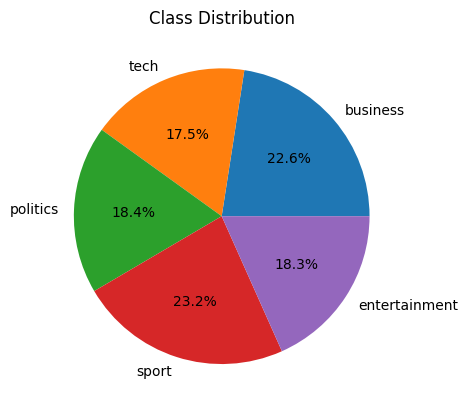

In [12]:
# Checking class imbalance

label_counts = []
for s in label_map: label_counts.append(len(df[df.Category==s]))
print({x: y for x, y in zip(label_map, label_counts)})

plt.pie(label_counts, labels=label_map, autopct="%.1f%%")
plt.title("Class Distribution")
plt.show()

In [13]:
df["word_count"] = df.Text.apply(lambda x: len(nlp(x)))
df

,Text,Category,word_count
0,worldcom ex boss launch defence lawyer defend ...,business,185
1,german business confidence slide german busine...,business,185
2,bbc poll indicate economic gloom citizen major...,business,253
3,lifestyle govern mobile choice fast well funky...,tech,308
4,enron boss $ m payout enron director agree $ m...,business,199
...,...,...,...
1485,double eviction big brother model caprice holb...,entertainment,112
1486,dj double act revamp chart dj duo jk joel take...,entertainment,274
1487,weak dollar hit reuters revenue medium group r...,business,136
1488,apple ipod family expand market apple expand i...,tech,287


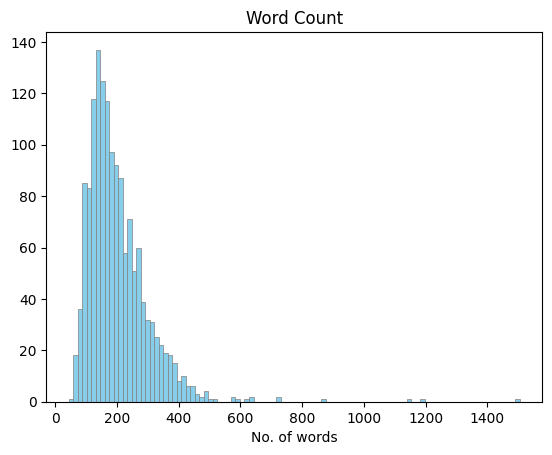

In [14]:
plt.hist(df.word_count, 100, color="skyblue", linewidth=0.5, edgecolor="gray")
plt.title("Word Count")
plt.xlabel("No. of words")
plt.show()

## Model Training

In [15]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, classification_report

In [16]:
label_map = np.loadtxt("../dataset/label_map.csv", delimiter=",", dtype=str).tolist()
df = pd.read_csv("../dataset/preprocessed.csv")
df.head()

,Text,Category
0,worldcom ex boss launch defence lawyer defend ...,business
1,german business confidence slide german busine...,business
2,bbc poll indicate economic gloom citizen major...,business
3,lifestyle govern mobile choice fast well funky...,tech
4,enron boss $ m payout enron director agree $ m...,business


In [17]:
Y = getLabels(df.Category, label_map)

X_train, X_test, Y_train, Y_test = train_test_split(df.Text.to_numpy(), Y, test_size=0.2, random_state=234)

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [19]:
models = {"LR": {"model": LogisticRegression(random_state=320),
                 "params": {"C": [0.001, 0.01, 0.1, 1]}},
          
          "KNN": {"model": KNeighborsClassifier(),
                  "params": {"n_neighbors": [5, 10, 20, 100], 
                             "weights": ["uniform", "distance"]}},
          
          "Random Forest": {"model": RandomForestClassifier(random_state=2806),
                            "params": {"n_estimators": [10, 100],
                                       "max_depth": [100, 200, None],
                                       }},
          
          "NB": {"model": MultinomialNB(),
                  "params": {"alpha": [0.001, 0.01, 0.1, 1]}}}

In [20]:
def GridSearch(models, X_train, Y_train, X_test, Y_test):
    scores = {"model":[], "Test F1": [], "best params": []}
    for name, m in models.items():
        gscv = GridSearchCV(m["model"], m["params"], verbose=2, n_jobs=2)
        gscv.fit(X_train, Y_train)
        scores["model"].append(name)
        scores["Test F1"].append(f1_score(gscv.predict(X_test), Y_test, average="macro"))
        scores["best params"].append(gscv.best_params_)
    return scores

model_scores = GridSearch(models, X_train, Y_train, X_test, Y_test)
    

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [21]:
pd.DataFrame(model_scores)

,model,Test F1,best params
0,LR,0.970000,{'C': 1}
1,KNN,0.956901,"{'n_neighbors': 20, 'weights': 'distance'}"
2,Random Forest,0.953847,"{'max_depth': 100, 'n_estimators': 100}"
3,NB,0.972690,{'alpha': 0.1}


In [22]:
# Generating test report for LR
model = LogisticRegression()
model.fit(X_train, Y_train)
print(classification_report(Y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95        63
           1       0.95      0.98      0.97        59
           2       0.97      0.95      0.96        61
           3       1.00      0.98      0.99        66
           4       1.00      0.96      0.98        49

    accuracy                           0.97       298
   macro avg       0.97      0.97      0.97       298
weighted avg       0.97      0.97      0.97       298



In [23]:
# Training the model on full data for future inference

import joblib as jl

X = vectorizer.transform(df.Text.to_numpy())
model = LogisticRegression().fit(X, Y)
jl.dump(model, "../ckpts/LR.model")

['../ckpts/LR.model']